In [ ]:
!pip install mysql.connector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 91.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247953 sha256=5d07db10589ae15a2a06adbfe9c25a97625692cb957c56cb01d5fa52d7b5f7e6
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177716d4a7d363d2bbe83bf6cf
Successfully built mysql.connector


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from keras.utils import plot_model

import mysql.connector as msql
from mysql.connector import Error

In [ ]:
# Connect to Database

conn = msql.connect(host='0.0.0.0',
                    user='user',
                    password='password')

cursor = conn.cursor()
print("Database is connected")
cursor.execute("use dcmdb")
print("Connected to dcmdb")

Database is connected
Connected to dcmdb


In [ ]:
# Truncate ITEM_RATING table before recalculating item rating

cursor.execute("TRUNCATE TABLE ITEM_RATING")
conn.commit()
print("All records in ITEM_RATING table are deleted")

All records in ITEM_RATING table are deleted


In [ ]:
# Recalculating ITEM_RATING table by the latest USER_ORDER records

cursor.execute('''
  INSERT INTO ITEM_RATING
  SELECT
  USER_ID,
  ITEM_ID,
  SUM(ORDER_ITEM_QTY) AS RATING
  FROM USER_ORDER A
  INNER JOIN ORDER_ITEM B
  ON A.ORDER_ID = B.ORDER_ID
  GROUP BY USER_ID, ITEM_ID
  ORDER BY USER_ID, ITEM_ID
  ''')
conn.commit()
print("ITEM_RATING table is reloaded")

ITEM_RATING table is reloaded


In [ ]:
# Retrieve recalculated item rating result from database

SQL_Query = pd.read_sql_query('''
  SELECT
  USER_ID,
  ITEM_ID,
  RATING
  FROM ITEM_RATING
''', conn)
df = pd.DataFrame(SQL_Query)

<ipython-input-6-9c9ae1b80629>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  SQL_Query = pd.read_sql_query('''


In [ ]:
df.head()

,USER_ID,ITEM_ID,RATING
0,1000,5371,1
1,1000,6753,1
2,1000,7576,1
3,1000,26955,2
4,1000,32897,1


In [ ]:
# Preprocessing Data
# Encode users and items as integer indices

# Get a list of User_Id
user_ids = df["USER_ID"].unique().tolist()

# Assign sequential number to every User_Id for indexing
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

# For each index number assign the corresponding User_Id
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Get a list of Item_Id
item_ids = df["ITEM_ID"].unique().tolist()

# Assign sequential number to every Item_Id for indexing
item2item_encoded = {x: i for i, x in enumerate(item_ids)}

# For each index number assign the corresponding Item_Id
item_encoded2item = {i: x for i, x in enumerate(item_ids)}

# Create new columns for user_encoded and item_encoded
df["user"] = df["USER_ID"].map(user2user_encoded)
df["item"] = df["ITEM_ID"].map(item2item_encoded)

In [ ]:
num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["rating"] = df["RATING"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 3898, Number of Items: 325, Min rating: 1.0, Max rating: 6.0


In [ ]:
# Prepare training and validation data

# Selects all rows from the DataFrame df in a random order
# Using a random seed of 42 to ensure the same order is obtained each time the code is run
df = df.sample(frac=1, random_state=42)

# Create an array for user with item
x = df[["user", "item"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])

# x_train = user, item. y_train = rating
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
# Create the model with embedding layer
# Embedding layer is a layer specifically designed to learn and represent categorical or discrete input data in a continuous vector space.
# It is used for text where each word or token is mapped to a dense vector representation, known as an embedding.
# The embedding layer allows the model to learn meaningful representations that capture similarities and relationships between different categories.

# Embed both users and items in to 50-dimensional vectors.
# The model computes a match score between user and movie embeddings via a dot product, and adds a per-item and per-user bias.
# The match score is scaled to the [0, 1] interval via a sigmoid, as our ratings are normalized to this range.

EMBEDDING_SIZE = 50

class discountmateRecommender(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


In [ ]:
model = discountmateRecommender(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
# Train the model based on the data split

history = model.fit(
    x=x_train, # user and movie
    y=y_train, # rating
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
466/466 [==============================] - 16s 19ms/step - loss: 0.4309 - val_loss: 0.1678
Epoch 2/5
466/466 [==============================] - 3s 7ms/step - loss: 0.1576 - val_loss: 0.1872
Epoch 3/5
466/466 [==============================] - 3s 6ms/step - loss: 0.1544 - val_loss: 0.1843
Epoch 4/5
466/466 [==============================] - 4s 9ms/step - loss: 0.1523 - val_loss: 0.1816
Epoch 5/5
466/466 [==============================] - 3s 6ms/step - loss: 0.1502 - val_loss: 0.1842


In [ ]:
# Store model fitting result in a variable

model_history = history

# Save  DataFrame for plotting chart

model_history_df = pd.DataFrame(model_history.history)
model_history_df

,loss,val_loss
0,0.430946,0.167833
1,0.157624,0.187235
2,0.154429,0.184306
3,0.152324,0.181587
4,0.150165,0.184249


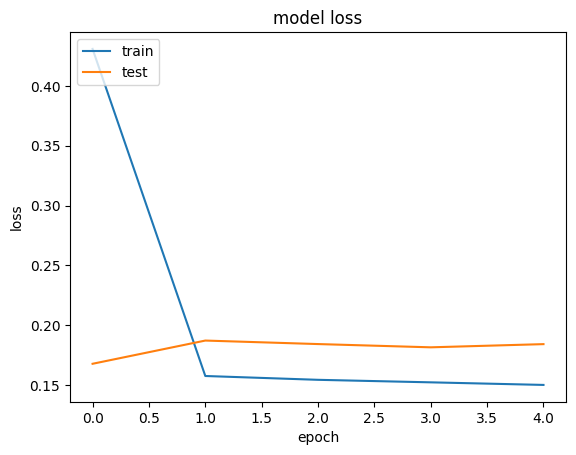

In [ ]:
# Plot training and validation loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
# Retrieve ITEM data from Database

Load_Item_SQL_Query = pd.read_sql_query('''
  SELECT
  A.ITEM_ID,
  A.ITEM_NAME,
  B.CAT_NAME
  FROM ITEM A
  LEFT JOIN CATEGORY B
  ON A.CAT_ID = B.CAT_ID
''', conn)
item_df = pd.DataFrame(Load_Item_SQL_Query)

<ipython-input-16-f6c8363c0ba7>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Load_Item_SQL_Query = pd.read_sql_query('''


In [ ]:
item_df.head()

,ITEM_ID,ITEM_NAME,CAT_NAME
0,844,Jagermeister Liqueur 700ml,Liquor
1,1240,Yalumba Cask Wine Chardonnay 2l,Liquor
2,1793,Connoisseur Ice Cream Cafe Grande 1l Tub,Freezer
3,2108,Vittoria Ground Coffee Italian Blend 1kg,Drinks
4,2205,Tasmanian Heritage Camembert Cheese 125g,"Dairy, Eggs & Fridge"


In [ ]:
# Get one user and check the system recommendations

user_id = df.USER_ID.sample(1).iloc[0]
items_bought_by_user = df[df.USER_ID == user_id]
items_not_bought = item_df[
    ~item_df["ITEM_ID"].isin(items_bought_by_user.ITEM_ID.values)
]["ITEM_ID"]
items_not_bought = list(
    set(items_not_bought).intersection(set(item2item_encoded.keys()))
)
items_not_bought = [[item2item_encoded.get(x)] for x in items_not_bought]
user_encoder = user2user_encoded.get(user_id)
user_item_array = np.hstack(
    ([[user_encoder]] * len(items_not_bought), items_not_bought)
)
ratings = model.predict(user_item_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    item_encoded2item.get(items_not_bought[x][0]) for x in top_ratings_indices
]

5/5 [==============================] - 0s 4ms/step


In [ ]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 10)
print("Items with high ratings from user")
print("----" * 10)

top_items_user = (
    items_bought_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .ITEM_ID.values
)
item_df_rows = item_df[item_df["ITEM_ID"].isin(top_items_user)]
for row in item_df_rows.itertuples():
    print("Item: ", row.ITEM_NAME, " | Category: ", row.CAT_NAME)

Showing recommendations for user: 3925
Items with high ratings from user
----------------------------------------
Item:  Tasmanian Heritage Camembert Cheese 125g  | Category:  Dairy, Eggs & Fridge
Item:  Sanpellegrino Natural Mineral Water 250ml X6 Pack  | Category:  Drinks
Item:  Wild Turkey Honey Liqueur 700ml  | Category:  Liquor
Item:  Mainland On The Go Cheese Crackers Balsamic Beetroot Relish 110g  | Category:  Dairy, Eggs & Fridge
Item:  On The Menu Beef Rissole Frozen Meal 320g  | Category:  Freezer


In [ ]:
print("----" * 10)
print("Top 10 item recommendations")
print("----" * 10)
recommended_items = item_df[item_df["ITEM_ID"].isin(recommended_item_ids)]
for row in recommended_items.itertuples():
    print("Item: ", row.ITEM_NAME, " | Category: ", row.CAT_NAME)

----------------------------------------
Top 10 item recommendations
----------------------------------------
Item:  Golden Circle Fruit Drinks Lunch Box Poppers Multipack Golden Pash 250ml X6 Pack  | Category:  Drinks
Item:  Twinings English Breakfast Tea Bags 10 Pack  | Category:  Drinks
Item:  Mccain Mixed Vegetables Peas Corn & Carrot 500g  | Category:  Freezer
Item:  Woolworths Mushrooms Cups 500g Punnet  | Category:  Fruit & Veg
Item:  Jalna Biodynamic Whole Milk Yoghurt 1kg  | Category:  Dairy, Eggs & Fridge
Item:  Potato White Washed Each  | Category:  Fruit & Veg
Item:  Devondale Semi Skim Long Life Milk 1l  | Category:  Dairy, Eggs & Fridge
Item:  Woolworths Spring Water 1.5l Bottle  | Category:  Drinks
Item:  Devondale 3 Cheese Blend Shredded Cheese 600g  | Category:  Dairy, Eggs & Fridge
Item:  D'orsogna Roast Chicken 320g  | Category:  Meat, Seafood & Deli


In [ ]:
# Get another user and check the system recommendations

user_id = df.USER_ID.sample(1).iloc[0]
items_bought_by_user = df[df.USER_ID == user_id]
items_not_bought = item_df[
    ~item_df["ITEM_ID"].isin(items_bought_by_user.ITEM_ID.values)
]["ITEM_ID"]
items_not_bought = list(
    set(items_not_bought).intersection(set(item2item_encoded.keys()))
)
items_not_bought = [[item2item_encoded.get(x)] for x in items_not_bought]
user_encoder = user2user_encoded.get(user_id)
user_item_array = np.hstack(
    ([[user_encoder]] * len(items_not_bought), items_not_bought)
)
ratings = model.predict(user_item_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    item_encoded2item.get(items_not_bought[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 10)
print("Items with high ratings from user")
print("----" * 10)

top_items_user = (
    items_bought_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .ITEM_ID.values
)
item_df_rows = item_df[item_df["ITEM_ID"].isin(top_items_user)]
for row in item_df_rows.itertuples():
    print("Item: ", row.ITEM_NAME, " | Category: ", row.CAT_NAME)

print("----" * 10)
print("Top 10 item recommendations")
print("----" * 10)
recommended_items = item_df[item_df["ITEM_ID"].isin(recommended_item_ids)]
for row in recommended_items.itertuples():
    print("Item: ", row.ITEM_NAME, " | Category: ", row.CAT_NAME)

5/5 [==============================] - 0s 4ms/step
Showing recommendations for user: 4172
Items with high ratings from user
----------------------------------------
Item:  Golden Circle Fruit Drinks Lunch Box Poppers Multipack Golden Pash 250ml X6 Pack  | Category:  Drinks
Item:  Pampas Shortcrust Pastry 5 Sheets 1kg  | Category:  Freezer
Item:  Gluten Free Bakehouse Garlic Bread 300g  | Category:  Freezer
Item:  President Butter Unsalted 200g  | Category:  Dairy, Eggs & Fridge
Item:  Jalna Biodynamic Whole Milk Yoghurt 1kg  | Category:  Dairy, Eggs & Fridge
----------------------------------------
Top 10 item recommendations
----------------------------------------
Item:  Devondale 100% Pure Full Cream Long Life Milk 1l  | Category:  Dairy, Eggs & Fridge
Item:  Twinings English Breakfast Tea Bags 10 Pack  | Category:  Drinks
Item:  Mccain Mixed Vegetables Peas Corn & Carrot 500g  | Category:  Freezer
Item:  Woolworths Mushrooms Cups 500g Punnet  | Category:  Fruit & Veg
Item:  Potato 

In [ ]:
# Insert system recommendations result to database RECOMMEND_ITEM_COLLAB_FILTER table

for index, row in df.head(1).iterrows():
  user_id = row['USER_ID']
  items_watched_by_user = df[df.USER_ID == user_id]
  items_not_bought = item_df[
      ~item_df["ITEM_ID"].isin(items_watched_by_user.ITEM_ID.values)
  ]["ITEM_ID"]
  items_not_bought = list(
      set(items_not_bought).intersection(set(item2item_encoded.keys()))
  )
  items_not_bought = [[item2item_encoded.get(x)] for x in items_not_bought]
  user_encoder = user2user_encoded.get(user_id)
  user_item_array = np.hstack(
      ([[user_encoder]] * len(items_not_bought), items_not_bought)
  )
  ratings = model.predict(user_item_array).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_item_ids = [
      item_encoded2item.get(items_not_bought[x][0]) for x in top_ratings_indices
  ]

  recommended_items = item_df[item_df["ITEM_ID"].isin(recommended_item_ids)]
  for row in recommended_items.itertuples():
      print(user_id, " : ", row.ITEM_NAME, ":", row.CAT_NAME)
      RCM_USER_ID = str(user_id)
      RCM_ITEM_ID = str(row.ITEM_ID)
      cursor.execute("""
                      INSERT INTO RECOMMEND_ITEM_COLLAB_FILTER (
                      RCM_USER_ID,
                      RCM_ITEM_ID,
                      RCM_COM_ID,
                      RCM_INSERT_DATE
                      )
                      VALUES (
                      """ + RCM_USER_ID + """,
                      """ + RCM_ITEM_ID + """,
                      1,
                      CURDATE()
                      )
                      """)
      print("Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: " + RCM_USER_ID + " | ITEM_ID: " + RCM_ITEM_ID)
      conn.commit()

5/5 [==============================] - 0s 3ms/step
2479.0  :  Golden Circle Fruit Drinks Lunch Box Poppers Multipack Golden Pash 250ml X6 Pack : Drinks
Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: 2479.0 | ITEM_ID: 7576
2479.0  :  Twinings English Breakfast Tea Bags 10 Pack : Drinks
Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: 2479.0 | ITEM_ID: 41946
2479.0  :  Mccain Mixed Vegetables Peas Corn & Carrot 500g : Freezer
Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: 2479.0 | ITEM_ID: 54233
2479.0  :  Capsicum Green Each : Fruit & Veg
Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: 2479.0 | ITEM_ID: 135156
2479.0  :  Woolworths Mushrooms Cups 500g Punnet : Fruit & Veg
Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: 2479.0 | ITEM_ID: 149963
2479.0  :  Truss Tomatoes Each : Fruit & Veg
Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: 2479.0 | ITEM_ID: 169438
2479.0  :  Potato White Washed Each : Fruit & Veg
Insert into RECOMMEND_ITEM_COLLAB_FILTER. USER_ID: 2479.0 | 

In [ ]:
conn.close()
print('Closed connection to DiscountMate database')

Closed connection to DiscountMate database
